# Description 

Train different classical ML models after electrode selection using RFE for each subject (subject depedent).

# setting up the environment

In [1]:
RELATIVE_PATH = '../../data/'
FILE_PARAM = 'Subject_1.mat'

In [2]:
import sys
sys.path.append('../../src')  
from data_loading import load_and_combine_mat_data
from preprocessing import preprocess_data
from evaluation import evaluate_model
from feature_selection import get_subject_indices
from ml_feature_extraction import extract_features

from sklearn import svm
import pandas as pd
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import welch, butter, filtfilt
from scipy.signal import butter, filtfilt
from sklearn.preprocessing import RobustScaler
from scipy.stats import kurtosis, skew, entropy
from scipy.signal import welch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier


# Data Loading

In [45]:
mat_file_paths = [RELATIVE_PATH + FILE_PARAM]
X, y, Channels = load_and_combine_mat_data(mat_file_paths)

Combined EEG Data Shape (Samples, Channels, Trials): (512, 128, 200)
Combined Labels Shape: (200,)
Channels: ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A20', 'A21', 'A22', 'A23', 'A24', 'A25', 'A26', 'A27', 'A28', 'A29', 'A30', 'A31', 'A32', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'B13', 'B14', 'B15', 'B16', 'B17', 'B18', 'B19', 'B20', 'B21', 'B22', 'B23', 'B24', 'B25', 'B26', 'B27', 'B28', 'B29', 'B30', 'B31', 'B32', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C30', 'C31', 'C32', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'D16', 'D17', 'D18', 'D19', 'D20', 'D21', 'D22', 'D23', 'D24', 'D25', 'D26', 'D27', 'D28', 'D29', 'D30', 'D31', 'D32']


In [46]:
indices = get_subject_indices(FILE_PARAM)

In [47]:
X = X[:,indices,:]

In [48]:
X.shape

(512, 8, 200)

# Data Preprocessing

In [49]:
X_preprocessed = preprocess_data(X)
print("Shape after preprocessing:", X_preprocessed.shape)

Shape after preprocessing: (512, 8, 200)


# Data Extraction

In [50]:
# Extract time-domain and frequency-domain features
feature_matrix_time, feature_matrix_freq = extract_features(X_preprocessed)

In [51]:
# Concatenate features for combined feature set
features_combined = np.hstack((feature_matrix_time, feature_matrix_freq))
print("Combined Features Shape:", features_combined.shape)

Combined Features Shape: (200, 136)


# Modeling

In [53]:
# List of classifiers
classifiers = {
    "SVM": svm.SVC(kernel='linear'),
    "KNN": KNeighborsClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(algorithm='SAMME'),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}

# Evaluate each feature set separately
feature_sets = {
    "Time Domain": feature_matrix_time,
    "Frequency Domain": feature_matrix_freq,
    "Both": features_combined
}

# Initialize dictionaries to store results
train_accuracies = {feature_name: [] for feature_name in feature_sets}
test_accuracies = {feature_name: [] for feature_name in feature_sets}

# Loop through each feature set
for feature_name, feature_data in feature_sets.items():
    print(f"\nEvaluating classifiers using {feature_name} features...")

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(feature_data, y, test_size=0.2, random_state=42, stratify=y)

    # Initialize RobustScaler and fit on training data, transform both train and test data
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Loop over each classifier
    for name, model in classifiers.items():
        print(f"\nEvaluating {name} with {feature_name} features...")

        # Train the model
        model.fit(X_train_scaled, y_train)

        # Call evaluate_model function to get evaluation metrics for each classifier
        evaluation_results = evaluate_model(model, X_test_scaled, y_test, X_train_scaled, y_train)
        
        
        train_accuracies[feature_name].append(evaluation_results['train_accuracy'])
        test_accuracies[feature_name].append(evaluation_results['test_accuracy'])
        
        # Print results for each classifier
        print(f"{name} - {feature_name} Test Accuracy: {evaluation_results['test_accuracy']}")
        print(f"{name} - {feature_name} Train Accuracy: {evaluation_results['train_accuracy']}")
        print("-" * 50)


Evaluating classifiers using Time Domain features...

Evaluating SVM with Time Domain features...
Test Accuracy: 0.475
Classification Report Test:
               precision    recall  f1-score   support

         0.0       0.39      0.70      0.50        10
         1.0       0.57      0.40      0.47        10
         2.0       0.50      0.30      0.38        10
         3.0       0.56      0.50      0.53        10

    accuracy                           0.47        40
   macro avg       0.50      0.48      0.47        40
weighted avg       0.50      0.47      0.47        40

Train Accuracy: 0.96875
Classification Report Train:
               precision    recall  f1-score   support

         0.0       0.97      0.95      0.96        40
         1.0       0.97      0.97      0.97        40
         2.0       0.95      1.00      0.98        40
         3.0       0.97      0.95      0.96        40

    accuracy                           0.97       160
   macro avg       0.97      0.97   

/home/jovyan/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:50:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Test Accuracy: 0.4
Classification Report Test:
               precision    recall  f1-score   support

         0.0       0.43      0.60      0.50        10
         1.0       0.50      0.40      0.44        10
         2.0       0.29      0.20      0.24        10
         3.0       0.36      0.40      0.38        10

    accuracy                           0.40        40
   macro avg       0.39      0.40      0.39        40
weighted avg       0.39      0.40      0.39        40

Train Accuracy: 1.0
Classification Report Train:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        40
         1.0       1.00      1.00      1.00        40
         2.0       1.00      1.00      1.00        40
         3.0       1.00      1.00      1.00        40

    accuracy                           1.00       160
   macro avg       1.00      1.00      1.00       160
weighted avg       1.00      1.00      1.00       160

XGBoost - Time Domain Test Accur

/home/jovyan/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:50:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Test Accuracy: 0.5
Classification Report Test:
               precision    recall  f1-score   support

         0.0       0.62      0.50      0.56        10
         1.0       0.46      0.60      0.52        10
         2.0       0.50      0.40      0.44        10
         3.0       0.45      0.50      0.48        10

    accuracy                           0.50        40
   macro avg       0.51      0.50      0.50        40
weighted avg       0.51      0.50      0.50        40

Train Accuracy: 1.0
Classification Report Train:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        40
         1.0       1.00      1.00      1.00        40
         2.0       1.00      1.00      1.00        40
         3.0       1.00      1.00      1.00        40

    accuracy                           1.00       160
   macro avg       1.00      1.00      1.00       160
weighted avg       1.00      1.00      1.00       160

XGBoost - Frequency Domain Test 

/home/jovyan/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:50:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Test Accuracy: 0.55
Classification Report Test:
               precision    recall  f1-score   support

         0.0       0.64      0.70      0.67        10
         1.0       0.60      0.60      0.60        10
         2.0       0.50      0.30      0.38        10
         3.0       0.46      0.60      0.52        10

    accuracy                           0.55        40
   macro avg       0.55      0.55      0.54        40
weighted avg       0.55      0.55      0.54        40

Train Accuracy: 1.0
Classification Report Train:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        40
         1.0       1.00      1.00      1.00        40
         2.0       1.00      1.00      1.00        40
         3.0       1.00      1.00      1.00        40

    accuracy                           1.00       160
   macro avg       1.00      1.00      1.00       160
weighted avg       1.00      1.00      1.00       160

XGBoost - Both Test Accuracy: 0

# Visualization

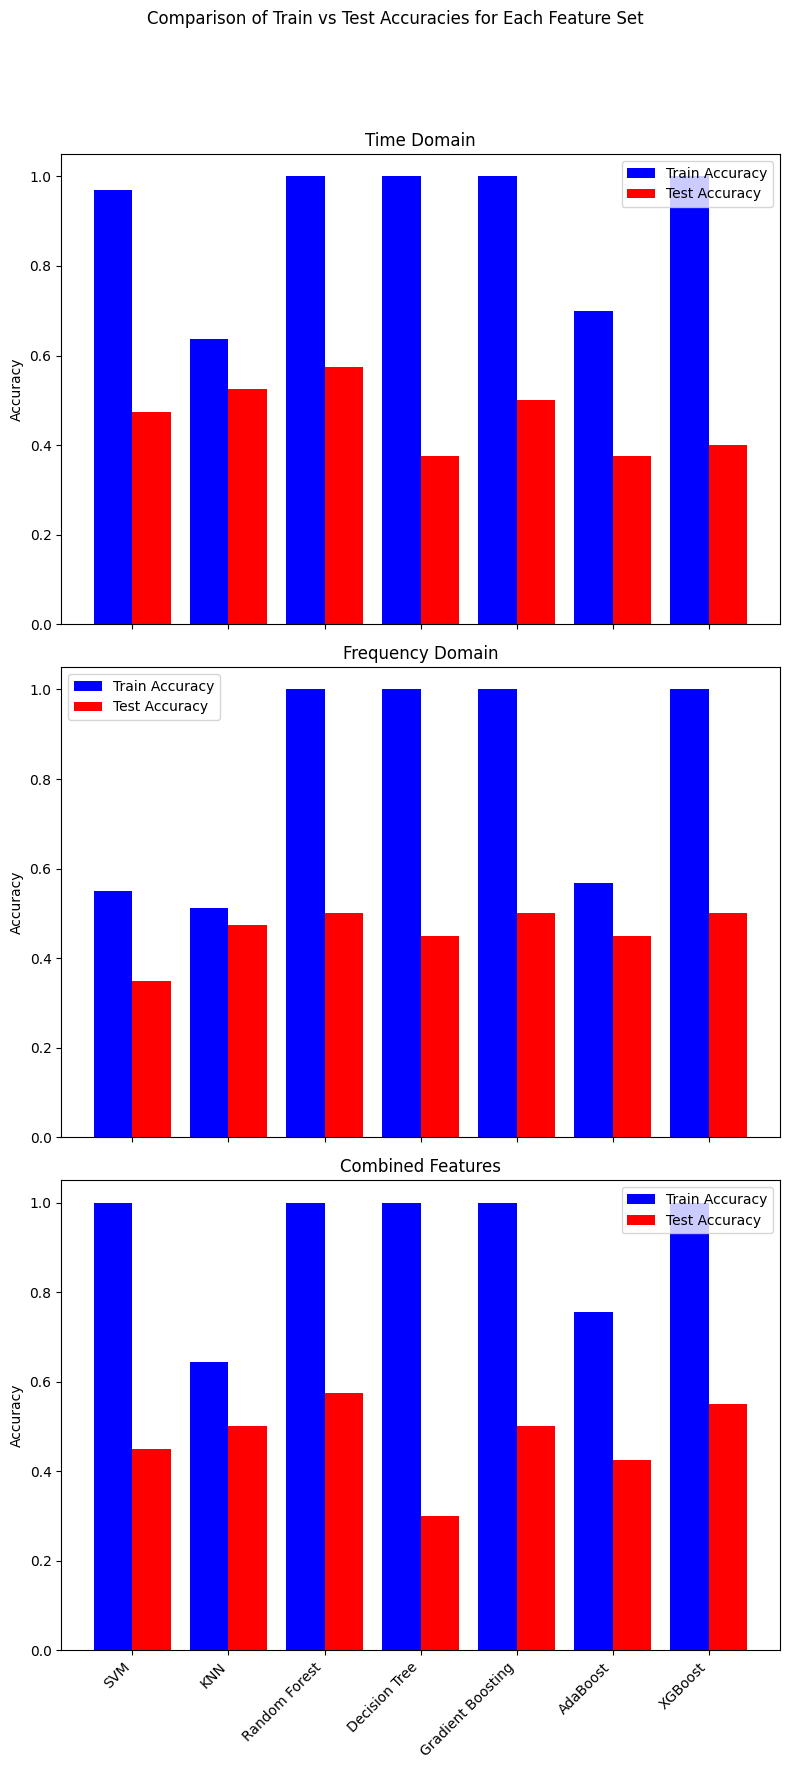

In [54]:
# Prepare data for plotting
classifiers_list = list(classifiers.keys())

# Time Domain
time_domain_train_accuracies = train_accuracies['Time Domain']
time_domain_test_accuracies = test_accuracies['Time Domain']

# Frequency Domain
freq_domain_train_accuracies = train_accuracies['Frequency Domain']
freq_domain_test_accuracies = test_accuracies['Frequency Domain']

# Combined Features
combined_train_accuracies = train_accuracies['Both']
combined_test_accuracies = test_accuracies['Both']

# Plotting the results as bar plots for each feature domain
fig, axes = plt.subplots(3, 1, figsize=(8, 18), sharex=True)

# Time Domain Plot
axes[0].bar(np.arange(len(classifiers_list)) - 0.2, time_domain_train_accuracies, 0.4, label='Train Accuracy', color='b')
axes[0].bar(np.arange(len(classifiers_list)) + 0.2, time_domain_test_accuracies, 0.4, label='Test Accuracy', color='r')
axes[0].set_title('Time Domain')
axes[0].set_ylabel('Accuracy')
axes[0].set_xticks(np.arange(len(classifiers_list)))
axes[0].set_xticklabels(classifiers_list, rotation=45, ha='right')  # Rotate labels for readability
axes[0].legend()

# Frequency Domain Plot
axes[1].bar(np.arange(len(classifiers_list)) - 0.2, freq_domain_train_accuracies, 0.4, label='Train Accuracy', color='b')
axes[1].bar(np.arange(len(classifiers_list)) + 0.2, freq_domain_test_accuracies, 0.4, label='Test Accuracy', color='r')
axes[1].set_title('Frequency Domain')
axes[1].set_ylabel('Accuracy')
axes[1].set_xticks(np.arange(len(classifiers_list)))
axes[1].set_xticklabels(classifiers_list, rotation=45, ha='right')  # Rotate labels for readability
axes[1].legend()

# Combined Features Plot
axes[2].bar(np.arange(len(classifiers_list)) - 0.2, combined_train_accuracies, 0.4, label='Train Accuracy', color='b')
axes[2].bar(np.arange(len(classifiers_list)) + 0.2, combined_test_accuracies, 0.4, label='Test Accuracy', color='r')
axes[2].set_title('Combined Features')
axes[2].set_ylabel('Accuracy')
axes[2].set_xticks(np.arange(len(classifiers_list)))
axes[2].set_xticklabels(classifiers_list, rotation=45, ha='right')  # Rotate labels for readability
axes[2].legend()

# Add a general title for all subplots
plt.suptitle('Comparison of Train vs Test Accuracies for Each Feature Set')
plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Adjust top to fit the suptitle
plt.show()


# cross validation

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold
import numpy as np

# Define the number of folds for cross-validation
n_splits = 5

# Initialize dictionaries to store results for each classifier and feature set
cv_results = {feature_name: [] for feature_name in feature_sets}

# Stratified KFold cross-validation
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Loop through each feature set
for feature_name, feature_data in feature_sets.items():
    print(f"\nPerforming cross-validation for {feature_name} features...")

    # Loop through each classifier
    for name, model in classifiers.items():
        # Create a pipeline that first scales the data, then fits the model
        pipeline = Pipeline([
            ('scaler', RobustScaler()),
            ('classifier', model)
        ])

        # Perform cross-validation and store the mean accuracy
        scores = cross_val_score(pipeline, feature_data, y, cv=cv, scoring='accuracy')

        # Store the mean and standard deviation of the scores
        cv_results[feature_name].append({
            'classifier': name,
            'mean': np.mean(scores),
            'std': np.std(scores)
        })
        print(f"{name} - Mean Accuracy: {np.mean(scores):.4f}, Std Dev: {np.std(scores):.4f}")



Performing cross-validation for Time Domain features...


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)


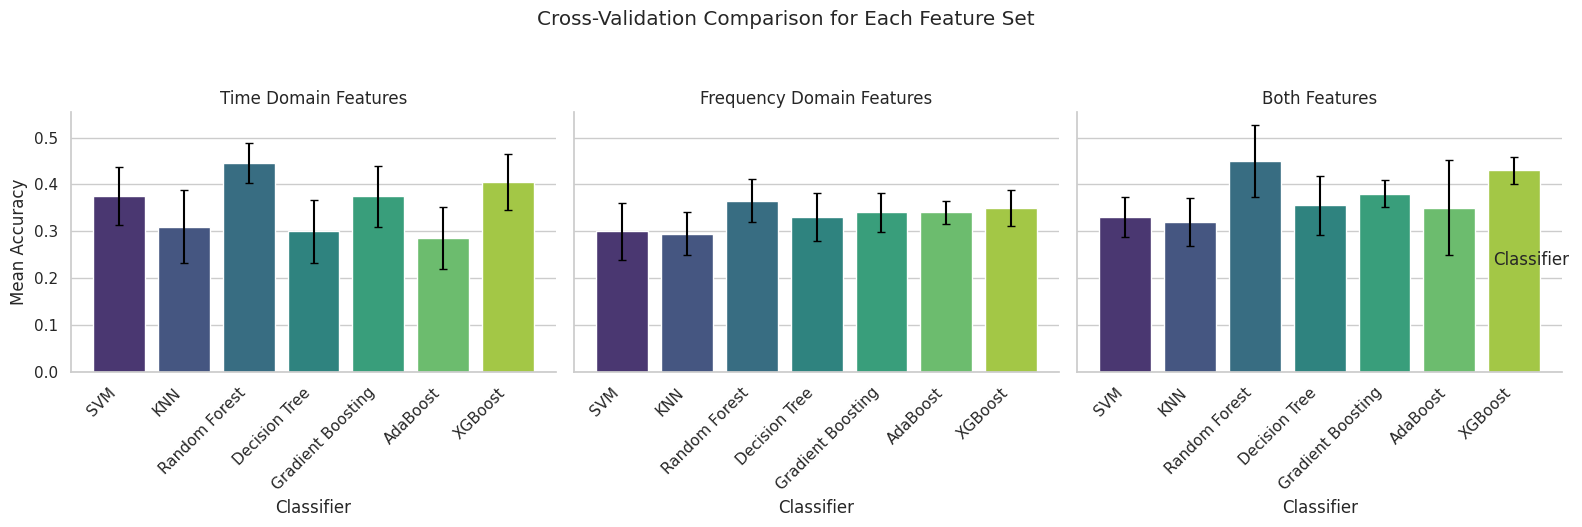

In [17]:
import seaborn as sns
import pandas as pd

# Prepare the data for seaborn plotting
data = []

for feature_name, results in cv_results.items():
    for i, classifier in enumerate(classifiers_list):
        data.append({
            'Feature Set': feature_name,
            'Classifier': classifier,
            'Mean Accuracy': results[i]['mean'],
            'Std Dev': results[i]['std']
        })

# Convert to DataFrame
df = pd.DataFrame(data)

# Set the style for seaborn
sns.set(style="whitegrid")

# Create a FacetGrid to display each feature set in a separate plot
g = sns.FacetGrid(df, col="Feature Set", height=5, aspect=1)
g.map_dataframe(
    sns.barplot,
    x="Classifier",
    y="Mean Accuracy",
    hue="Classifier",
    palette="viridis",
    ci=None
)

# Add error bars
for ax, feature_name in zip(g.axes.flat, cv_results.keys()):
    feature_results = df[df['Feature Set'] == feature_name]
    for i, (mean, std) in enumerate(zip(feature_results['Mean Accuracy'], feature_results['Std Dev'])):
        ax.errorbar(i, mean, yerr=std, fmt='none', c='black', capsize=3)

# Customize the plot appearance
g.set_axis_labels("Classifier", "Mean Accuracy")
g.set_titles("{col_name} Features")
g.set_xticklabels(rotation=45, ha='right')
g.add_legend(title="Classifier")
g.fig.suptitle('Cross-Validation Comparison for Each Feature Set', y=1.05)
plt.tight_layout()
plt.show()


# Hyperparameter Tuning

In [20]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import pandas as pd

# Parameter grids for each classifier
param_grids = {
    "SVM": {
        'C': [0.01, 0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
        'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1]
    },
    "KNN": {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance']
    },
    "Random Forest": {
        'n_estimators': [50, 100, 150],
        'max_depth': [None, 10, 20],
    },
    "Decision Tree": {
        'max_depth': [None, 10, 20],
        'criterion': ['gini', 'entropy']
    },
    "Gradient Boosting": {
        'n_estimators': [50, 100, 150],
        'learning_rate': [0.01, 0.1, 0.2]
    },
    "AdaBoost": {
        'n_estimators': [50, 100, 150],
        'learning_rate': [0.5, 1, 1.5]
    },
    "XGBoost": {
        'n_estimators': [50, 100, 150],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    }
}

# Initialize StratifiedKFold for cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store the best parameters and scores for each feature set
best_results = {feature_name: {} for feature_name in feature_sets.keys()}

# Perform grid search for each feature set
for feature_name, feature_data in feature_sets.items():
    print(f"\nStarting grid search for feature set: {feature_name}")

    # Loop through each classifier
    for name, model in classifiers.items():
        print(f"  - Performing grid search for {name}...")

        # Get the parameter grid for the current classifier
        param_grid = param_grids.get(name, {})

        # Set up GridSearchCV with cross-validation
        grid_search = GridSearchCV(model, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)

        # Fit GridSearchCV on the current feature set
        grid_search.fit(feature_data, y)

        # Save the best parameters and score for this classifier and feature set
        best_results[feature_name][name] = {
            'best_params': grid_search.best_params_,
            'best_score': grid_search.best_score_
        }

        # Print results for this classifier and feature set
        print(f"    {name} best parameters: {grid_search.best_params_}")
        print(f"    {name} best cross-validated accuracy: {grid_search.best_score_:.4f}")

# Convert results to a DataFrame
best_results_df = pd.DataFrame({
    (feature, clf): results
    for feature, clf_dict in best_results.items()
    for clf, results in clf_dict.items()
}).T
print("\nBest parameters and scores for each classifier and feature set:")
print(best_results_df)



Starting grid search for feature set: Time Domain
  - Performing grid search for SVM...
    SVM best parameters: {'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}
    SVM best cross-validated accuracy: 0.3900
  - Performing grid search for KNN...
    KNN best parameters: {'n_neighbors': 7, 'weights': 'distance'}
    KNN best cross-validated accuracy: 0.3700
  - Performing grid search for Random Forest...
    Random Forest best parameters: {'max_depth': 10, 'n_estimators': 100}
    Random Forest best cross-validated accuracy: 0.4450
  - Performing grid search for Decision Tree...
    Decision Tree best parameters: {'criterion': 'gini', 'max_depth': 20}
    Decision Tree best cross-validated accuracy: 0.3450
  - Performing grid search for Gradient Boosting...
    Gradient Boosting best parameters: {'learning_rate': 0.1, 'n_estimators': 50}
    Gradient Boosting best cross-validated accuracy: 0.3900
  - Performing grid search for AdaBoost...
    AdaBoost best parameters: {'learning_rate': 1.5

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:19:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


    XGBoost best parameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100}
    XGBoost best cross-validated accuracy: 0.4150

Starting grid search for feature set: Frequency Domain
  - Performing grid search for SVM...
    SVM best parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
    SVM best cross-validated accuracy: 0.3750
  - Performing grid search for KNN...
    KNN best parameters: {'n_neighbors': 3, 'weights': 'distance'}
    KNN best cross-validated accuracy: 0.3200
  - Performing grid search for Random Forest...
    Random Forest best parameters: {'max_depth': 10, 'n_estimators': 150}
    Random Forest best cross-validated accuracy: 0.4250
  - Performing grid search for Decision Tree...
    Decision Tree best parameters: {'criterion': 'gini', 'max_depth': 10}
    Decision Tree best cross-validated accuracy: 0.3650
  - Performing grid search for Gradient Boosting...
    Gradient Boosting best parameters: {'learning_rate': 0.01, 'n_estimators': 150}
    G

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:28:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


    XGBoost best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150}
    XGBoost best cross-validated accuracy: 0.3700

Starting grid search for feature set: Both
  - Performing grid search for SVM...
    SVM best parameters: {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
    SVM best cross-validated accuracy: 0.3900
  - Performing grid search for KNN...
    KNN best parameters: {'n_neighbors': 5, 'weights': 'distance'}
    KNN best cross-validated accuracy: 0.3600
  - Performing grid search for Random Forest...
    Random Forest best parameters: {'max_depth': 20, 'n_estimators': 150}
    Random Forest best cross-validated accuracy: 0.4850
  - Performing grid search for Decision Tree...
    Decision Tree best parameters: {'criterion': 'entropy', 'max_depth': None}
    Decision Tree best cross-validated accuracy: 0.3300
  - Performing grid search for Gradient Boosting...
    Gradient Boosting best parameters: {'learning_rate': 0.01, 'n_estimators': 150}
    Gradient Boost

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:38:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


    XGBoost best parameters: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100}
    XGBoost best cross-validated accuracy: 0.4450

Best parameters and scores for each classifier and feature set:
                                                                          best_params  \
Time Domain      SVM                     {'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}   
                 KNN                        {'n_neighbors': 7, 'weights': 'distance'}   
                 Random Forest                 {'max_depth': 10, 'n_estimators': 100}   
                 Decision Tree                 {'criterion': 'gini', 'max_depth': 20}   
                 Gradient Boosting         {'learning_rate': 0.1, 'n_estimators': 50}   
                 AdaBoost                 {'learning_rate': 1.5, 'n_estimators': 150}   
                 XGBoost            {'learning_rate': 0.2, 'max_depth': 3, 'n_esti...   
Frequency Domain SVM                  {'C': 10, 'gamma': 'scale', 'kernel': 'linear'

<Figure size 1200x800 with 0 Axes>

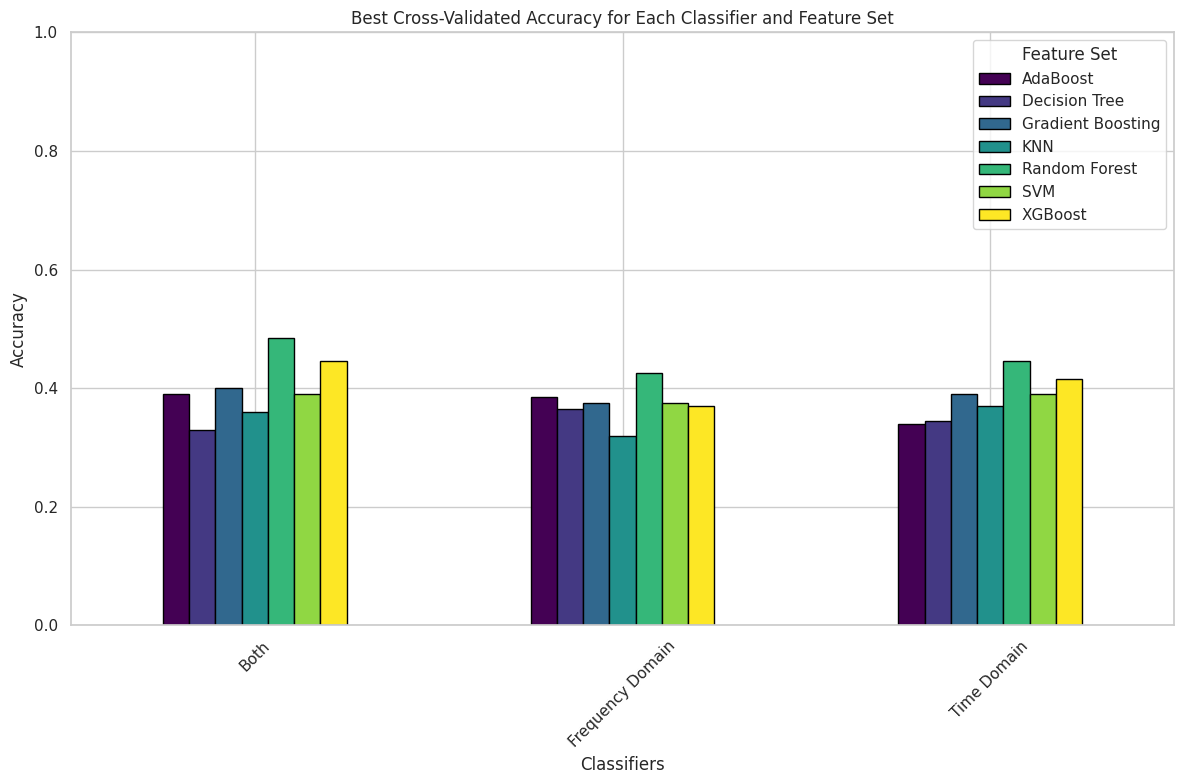

In [21]:
import matplotlib.pyplot as plt

# Extract the best scores for each feature set and classifier from the DataFrame
best_scores = best_results_df.apply(lambda x: x['best_score'], axis=1).unstack()

# Plotting the results
plt.figure(figsize=(12, 8))
best_scores.plot(kind='bar', figsize=(12, 8), colormap='viridis', edgecolor='black')

# Customize plot
plt.title("Best Cross-Validated Accuracy for Each Classifier and Feature Set")
plt.xlabel("Classifiers")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.legend(title="Feature Set")
plt.ylim(0, 1)
plt.tight_layout()

# Show plot
plt.show()
